# Vehicles Detection with Faster-RCNN on MobileNetV3
### End-to-end Object Detection

Author : Wong Zhao Wu

# Abstract
Vehicle detection is one of the core technologies behind the possibility of autonomous vehicles. Finding the perfect trade-off between accuracy and performance has been a challenge in solving the task of object detection for real-time inference. In this study, my goal is to build an end-to-end light weight object detection algorithm using [Faster-RCNN](https://arxiv.org/abs/1506.01497) coupled with [MobileNetV3](https://arxiv.org/abs/1905.02244) with [Feature Pyramid Network (FPN)](https://arxiv.org/abs/1612.03144). The final model has obtained mAP of 0.835 on the hold-out validation set.

For this part C of the assignment, I have spent many effort and countless hours attempting to understand the intuition and implementation details of object detection with Faster-RCNN. Finally, I really appreciate this opportunity for me to venture beyond the syllabus and I am looking forward to continue reading and expand my horizon on ways to further improvethe network or even using different SOTA architecture for better performance.

# Notebook Initialization

If you are running this notebook on Google Colab, you need to clone the private working repository.

## Downloading Dependencies

In [4]:
# Clone Repo for Dataset
!git clone https://github.com/kiritowu/Deep-Learning.git
%cd FasterRCNN-VehiclesDetection

Cloning into 'DELE-Temp-CA'...
remote: Enumerating objects: 1548, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 1548 (delta 163), reused 337 (delta 156), pack-reused 1196
Receiving objects: 100% (1548/1548), 378.70 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Checking out files: 100% (1287/1287), done.
/content/DELE-Temp-CA


## Import Modules & Set Default File Directory
The following lines will import all neccessary modules to build a Faster-RCNN modules and some utilities libraries to load, visualise and evaluate the performance of the model.

Since the packages on Google Colab is outdated (i.e. Albumentations), we need to manually Upgrade the packages to get the cells running.

Other than the raw Pytorch packages family (e.g. torch, torchvision), I have installed one extra packages named `mapcalc` to evaluate the performance of the model using mAP.

In [2]:
!pip install -U cython mapcalc albumentations

     |████████████████████████████████| 102 kB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 64 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import json
import math
import os
import random
import sys
import time

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import torch
import torch.utils.data
import torchvision
import albumentations as A

from PIL.Image import Image 
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision import transforms
from torchvision.ops import batched_nms
from torchvision.transforms import functional as F
from albumentations.pytorch.transforms import ToTensorV2

%matplotlib inline

BASE_FOLDER = os.getcwd()
print("Base Folder : {}".format(BASE_FOLDER))

Base Folder : c:\Users\wongz\Documents\Pro-Lang\Deep-Learning\CV\FasterRCNN_VehiclesDetection


In [6]:
from typing import List, Tuple

import torchvision.models as models

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, mobilenet_backbone
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

## Import Utils from Torchvision Github Page

In `references/detection/` from [Torchvision Github](https://github.com/pytorch/vision), we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/utils.py`

Let's copy those files (and their dependencies) in here so that they are available in the notebook.

> The following cells are commented since files needed is downloaded.

In [7]:
# # Lines below are commented since it is cloned in github repo
# %%shell

# # Download TorchVision repo to use some files from references/detection
# %cd ..
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# cp references/detection/utils.py ../
# %cd ..

Cloning into 'vision'...
remote: Enumerating objects: 55441, done.
remote: Counting objects: 100% (20911/20911), done.
remote: Compressing objects: 100% (3593/3593), done.
remote: Total 55441 (delta 17626), reused 20080 (delta 17103), pack-reused 34530
Receiving objects: 100% (55441/55441), 104.61 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (44174/44174), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [3]:
# Import utils.py for training and logging utilities
sys.path.append('..')
import utils

## Checking GPU

To load the model, you need to first enable GPU runtime on Google Colab through "Runtime >> Change runtime type >> Hardware accelerator >> GPU".

In [9]:
# check if cuda GPU is available, make sure you're using GPU runtime on Google Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # you should output "cuda"

cuda


# Vehicles Detection Dataset
In this notebook, I will be using the [Cars Object Detection Dataset](https://www.kaggle.com/sshikamaru/car-object-detection) that has been downloaded and extracted from Kaggle through the Kaggle API.

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
data/
  training_images/
    vid_4_600.jpg
    vid_4_620.jpg
    vid_4_640.jpg
    ...
  testing_images/
    vid_5_400.jpg
    vid_5_420.jpg
    vid_5_440.jpg
    ...
  train_solution_bounding_boxes (1).csv
  sample_submission.csv
```

Where `train_solution_bounding_boxes (1).csv` contains the labels for the training images annotated in PascalVOC Format.

### Defining the Dataset Adaptor and Dataset

The [torchvision reference scripts for training object detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation

Other than the `torch.utils.data.Dataset` class for the dataloader in Pytorch, an additional `CarsDatasetAdaptor` is written that to load the images and extract the bounding boxes from the `.csv` file with other utilities to visualise the image by the `image_id`.

In [11]:
training_data_path = os.path.join("data", "training_images")
data_csv = pd.read_csv("data/train_solution_bounding_boxes (1).csv")
data_csv.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [12]:
class CarsDatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe, subset:str):
        '''Load the image annotation file with all the bounding boxes and unique images.
        '''
        self.images_dir_path = images_dir_path
        self.annotations_df = annotations_dataframe.sample(frac=1) # Random Shuffle the Image
        # 80:20 Train-Validation split
        if subset == "training":
            self.image_df = self.annotations_df.iloc[:int(0.8*len(self.annotations_df))]
        elif subset == "validation":
            self.image_df = self.annotations_df.iloc[int(0.8*len(self.annotations_df)):]
        else:
            raise ValueError("subset should be string of only training or validation")
        self.images = self.image_df.image.unique().tolist()

    def __len__(self) -> int:
        return len(self.images)

    def get_image_and_labels_by_idx(
            self, index:int
        )->Tuple[Image, np.ndarray, np.ndarray, int]:
        '''Return the image, bounding boxes, the associated class label 
        (always 1 since only have a single class) based on the image_id.
        '''
        image_name = self.images[index]

        # Open PIL Image
        image = PIL.Image.open(os.path.join(self.images_dir_path, image_name))
        
        # Extract Pascal Bboxes
        pascal_bboxes = self.image_df[self.image_df.image == image_name][["xmin", "ymin", "xmax", "ymax"]].values
        
        # Set Class labels to 1 as only Single Class
        class_labels = np.ones(len(pascal_bboxes))

        return image, pascal_bboxes, class_labels, index
    
    def show_image(self, index:int):
        '''Visualise the image based on the image_id.
        '''
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)

        if bboxes.tolist() is not None:
            for bbox in bboxes:
                # Extract Pascal coordinates from bbox
                x1, y1, x2, y2 = bbox

                # Get bbox dimension from coordinates
                bottom_left = (x1, y2)
                width = x2 - x1
                height = y1 - y2

                # Draw rectangles
                rect_1 = matplotlib.patches.Rectangle(
                    bottom_left,
                    width,
                    height,
                    linewidth=4,
                    edgecolor="black",
                    fill=False,
                )
                rect_2 = matplotlib.patches.Rectangle(
                    bottom_left,
                    width,
                    height,
                    linewidth=2,
                    edgecolor="white",
                    fill=False,
                )
        
                # Add the patch to the Axes
                ax.add_patch(rect_1)
                ax.add_patch(rect_2)

        plt.show()

After defining the dataset adaptor, we can visualise the images with its bounding box by calling the `.show_image(<id>)` method.

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=676x380 at 0x7F5237764F10>, array([[435.7319738, 171.7414184, 527.3095412, 215.5497085],
       [237.8062637, 180.601522 , 316.5826657, 212.5963407]]), array([1., 1.]), 1)


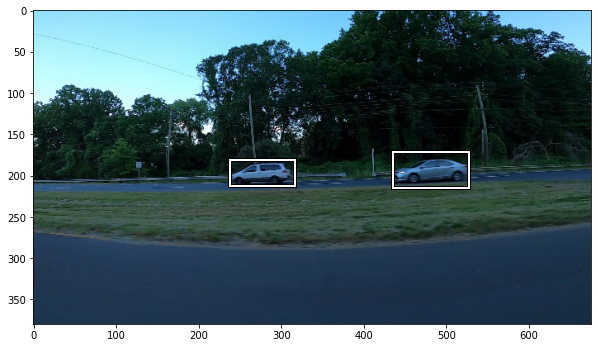

In [13]:
cars_train_ds = CarsDatasetAdaptor(training_data_path, data_csv, subset="training")
print(cars_train_ds.get_image_and_labels_by_idx(1))
cars_train_ds.show_image(1)

In [14]:
class EfficientDetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_adaptor, transforms):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        # Get image and its properties from the dataset adaptor.
        image, pascal_bboxes, class_labels, image_id = \
            self.ds.get_image_and_labels_by_idx(index) 

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        # Perform image augmentation using Albumentations
        sample = self.transforms(**sample) 
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]
        
        # Return the image, bounding boxes, labels and image_id
        target = {
            "boxes": torch.as_tensor(pascal_bboxes, dtype=torch.float32),
            "labels": torch.as_tensor(np.array(labels).astype(int), dtype=torch.int64),
            "image_id": torch.tensor([image_id]),
        }
        return image, target

    def __len__(self):
        return len(self.ds)

That's all for the dataset. Let's see how the outputs are structured for this dataset

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary containing several fields, including `boxes` and `labels`.

# Setting up the Model

In this notebook, I will make use of Faster R-CNN model with a MobileNetV3Small-FPN backbone.
The following cells define the hyperparameters and all neccessary functions to build the model.

In [15]:
# hyper-parameters
params = {'BATCH_SIZE': 8,
          'LR': 0.0005,
          'CLASSES': 1 + 1, # Background + Cars
          'MAXEPOCHS': 10,
          'BACKBONE': 'mobilenet_v3_small',
          'FPN': True,
          'ANCHOR_SIZE': ((16, 32, 64, 128, 256, ), ) * 3, # 3 Set of Anchors for 3 Feature Map outputed from FPN
          'ASPECT_RATIOS': ((0.5, 1.0, 2),), # Aspect Ratio for the anchors
          'MIN_SIZE': 512,
          'MAX_SIZE': 512,
          'IMG_MEAN': [0.485, 0.456, 0.406], #Imagenet Means and Std
          'IMG_STD': [0.229, 0.224, 0.225],
          'IOU_THRESHOLD': 0.5
          }

In [16]:
def get_resnet_backbone(backbone_name: str):
    """
    Returns a resnet backbone pretrained on ImageNet.
    Removes the average-pooling layer and the linear layer at the end.
    """
    if backbone_name == 'resnet18':
        pretrained_model = models.resnet18(pretrained=True, progress=False)
        out_channels = 512
    elif backbone_name == 'resnet34':
        pretrained_model = models.resnet34(pretrained=True, progress=False)
        out_channels = 512
    elif backbone_name == 'resnet50':
        pretrained_model = models.resnet50(pretrained=True, progress=False)
        out_channels = 2048
    elif backbone_name == 'resnet101':
        pretrained_model = models.resnet101(pretrained=True, progress=False)
        out_channels = 2048
    elif backbone_name == 'resnet152':
        pretrained_model = models.resnet152(pretrained=True, progress=False)
        out_channels = 2048

    backbone = torch.nn.Sequential(*list(pretrained_model.children())[:-2])
    backbone.out_channels = out_channels

    return backbone

In [17]:
def get_resnet_fpn_backbone(backbone_name: str):
    """
    Returns a specified ResNet backbone with FPN pretrained on ImageNet.
    """
    return resnet_fpn_backbone(backbone_name, pretrained=True, trainable_layers=3)

In [18]:
def get_mobilenet_fpn_backbone(backbone_name: str):
    """
    Returns a specified Mobilenet backbone with FPN pretrained on ImageNet.
    """
    return mobilenet_backbone(backbone_name, pretrained=True, fpn=True, trainable_layers=2)

In [63]:
def get_anchor_generator(anchor_size: Tuple[tuple] = None, aspect_ratios: Tuple[tuple] = None):
    """Returns the anchor generator."""
    if anchor_size is None:
        anchor_size = ((16,), (32,), (64,), (128,))
    if aspect_ratios is None:
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_size)

    anchor_generator = AnchorGenerator(sizes=anchor_size,
                                       aspect_ratios=aspect_ratios)
    return anchor_generator

In [19]:
def get_roi_pool(featmap_names: List[str] = None, output_size: int = 7, sampling_ratio: int = 2):
    """Returns the ROI Pooling"""
    if featmap_names is None:
        # default for resnet with FPN
        featmap_names = ['0', '1', '2', '3']

    roi_pooler = MultiScaleRoIAlign(featmap_names=featmap_names,
                                    output_size=output_size,
                                    sampling_ratio=sampling_ratio)

    return roi_pooler

In [20]:
def get_fasterRCNN(backbone: torch.nn.Module,
                   anchor_generator: AnchorGenerator,
                   roi_pooler: MultiScaleRoIAlign,
                   num_classes: int,
                   image_mean: List[float] = [0.485, 0.456, 0.406],
                   image_std: List[float] = [0.229, 0.224, 0.225],
                   min_size: int = 512,
                   max_size: int = 1024,
                   **kwargs
                   ):
    """Returns the Faster-RCNN model. Default normalization: ImageNet"""
    model = FasterRCNN(backbone=backbone,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler,
                       num_classes=num_classes,
                       image_mean=image_mean,  # ImageNet
                       image_std=image_std,  # ImageNet
                       min_size=min_size,
                       max_size=max_size,
                       **kwargs
                       )
    model.num_classes = num_classes
    model.image_mean = image_mean
    model.image_std = image_std
    model.min_size = min_size
    model.max_size = max_size

    return model

In [21]:
def get_fasterRCNN_resnet(num_classes: int,
                          backbone_name: str,
                          anchor_size: List[float],
                          aspect_ratios: List[float],
                          fpn: bool = True,
                          min_size: int = 512,
                          max_size: int = 1024,
                          **kwargs
                          ):
    """Returns the Faster-RCNN model with resnet backbone with and without fpn."""

    # Backbone
    if fpn:
        backbone = get_mobilenet_fpn_backbone(backbone_name=backbone_name) if "mobilenet" in backbone_name else get_resnet_fpn_backbone(backbone_name=backbone_name)
    else:
        backbone = get_resnet_backbone(backbone_name=backbone_name)

    # Anchors
    anchor_size = anchor_size
    aspect_ratios = aspect_ratios * len(anchor_size)
    anchor_generator = get_anchor_generator(anchor_size=anchor_size, aspect_ratios=aspect_ratios)

    # ROI Pool
    with torch.no_grad():
        backbone.eval()
        random_input = torch.rand(size=(1, 3, 512, 512))
        features = backbone(random_input)

    if isinstance(features, torch.Tensor):
        from collections import OrderedDict

        features = OrderedDict([('0', features)])

    featmap_names = [key for key in features.keys() if key.isnumeric()]

    roi_pool = get_roi_pool(featmap_names=featmap_names)

    # Model
    return get_fasterRCNN(backbone=backbone,
                          anchor_generator=anchor_generator,
                          roi_pooler=roi_pool,
                          num_classes=num_classes,
                          min_size=min_size,
                          max_size=max_size,
                          **kwargs)


In [64]:
model = get_fasterRCNN_resnet(num_classes=params['CLASSES'],
                              backbone_name=params['BACKBONE'],
                              anchor_size=params['ANCHOR_SIZE'],
                              aspect_ratios=params['ASPECT_RATIOS'],
                              fpn=params['FPN'],
                              min_size=params['MIN_SIZE'],
                              max_size=params['MAX_SIZE'],
                              image_mean=params['IMG_MEAN'],
                              image_std=params['IMG_STD'])

# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(512,), max_size=512, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activat

In [ ]:
# construct an Optimizer using AdamW optimizer
model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(model_params, lr = params['LR'], weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 2 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=2,
                                               gamma=0.1)

# Data Augmentation

For data augmentation, I have perform basic affine transformation and color jittering to increase the amount of training images and improve the generalization capabilities of the model using `Albumentations` module. Resizing is also applied to ensure training images and validation images have the same sizing.

In [53]:
def train_transform(img_size = 512):
    return A.Compose(
        [   
            A.Resize(img_size, img_size, always_apply=True),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15,p=0.5),
            A.Normalize(mean=0, std=1),
            A.ColorJitter(p=0.5),
            ToTensorV2()
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["labels"]
        )
    )

def test_transform(img_size = 512):
    return A.Compose(
        [
            A.Resize(img_size, img_size, always_apply=True),
            A.Normalize(mean=0, std=1),
            ToTensorV2()
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["labels"]
        )
    )

# Data Loaders

Let's now set up our data loaders so that we can streamline the batch loading of data for our model training later on.

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [54]:
NUM_WORKERS = 1

# use our dataset and defined transformations
train_dataset = EfficientDetDataset(CarsDatasetAdaptor(training_data_path, data_csv, subset="training"), train_transform())
val_dataset = EfficientDetDataset(CarsDatasetAdaptor(training_data_path, data_csv, subset="validation"), test_transform())

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=params['BATCH_SIZE'], shuffle=True,
    collate_fn=utils.collate_fn)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=params['BATCH_SIZE'], shuffle=False,
    collate_fn=utils.collate_fn)

After defining the data loader, we can visualise the effect of Image Augmentation by running the next cell.

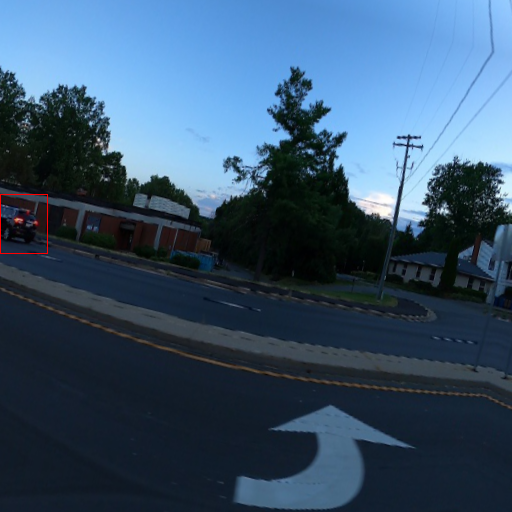

In [61]:
img, target = train_dataset[1]
# convert the image, which has been rescaled to 0-1 and had the channels flipped
pred_img = PIL.Image.fromarray((img.permute(1, 2, 0).mul(255).numpy()).astype(np.uint8))
draw = PIL.ImageDraw.Draw(pred_img)

img_preds = target
for i in range(len(img_preds["boxes"])):
    x1, y1, x2, y2 = img_preds["boxes"][i]
    label = int(img_preds["labels"][i])

    draw.rectangle(((x1, y1), (x2, y2)), outline="red")

display(pred_img)

# Model Training

And now let's train the model, evaluating at the end of every epoch.

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [ ]:
from mapcalc import calculate_map

@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    map_sum = 0

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        targets = [{k: v.tolist() for k, v in t.items()} for t in targets]
        outputs = [{k: v.tolist() for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        mAP = np.sum([calculate_map(target, output, iou_threshold=0.5) for target, output in zip(targets, outputs)])/len(targets)
        map_sum += mAP
        evaluator_time = time.time()

        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time, mAP_IOU=mAP)

    print("mAP@IOU=0.5 : {}".format(map_sum / len(data_loader)))
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)

    # accumulate predictions from all images
    torch.set_num_threads(n_threads)
    return 

In [ ]:
for epoch in range(params['MAXEPOCHS']):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
 
    # evaluate on the train dataset
    print("Training Score")
    evaluate(model, train_loader, device=device)

    # evaluate on the test dataset
    print("Testing Score")
    # evaluate(model, train_loader, device=device)
    evaluate(model, val_loader, device=device)

Epoch: [0]  [ 0/38]  eta: 0:00:10  lr: 0.000014  loss: 1.3949 (1.3949)  loss_classifier: 0.6351 (0.6351)  loss_box_reg: 0.0443 (0.0443)  loss_objectness: 0.7007 (0.7007)  loss_rpn_box_reg: 0.0147 (0.0147)  time: 0.2825  data: 0.1024  max mem: 1205
Epoch: [0]  [10/38]  eta: 0:00:07  lr: 0.000149  loss: 0.9208 (1.0032)  loss_classifier: 0.1842 (0.2838)  loss_box_reg: 0.0328 (0.0318)  loss_objectness: 0.6878 (0.6784)  loss_rpn_box_reg: 0.0080 (0.0092)  time: 0.2626  data: 0.0959  max mem: 1205
Epoch: [0]  [20/38]  eta: 0:00:04  lr: 0.000284  loss: 0.6411 (0.7177)  loss_classifier: 0.0443 (0.1654)  loss_box_reg: 0.0393 (0.0421)  loss_objectness: 0.5991 (0.5014)  loss_rpn_box_reg: 0.0080 (0.0089)  time: 0.2579  data: 0.0934  max mem: 1205
Epoch: [0]  [30/38]  eta: 0:00:02  lr: 0.000419  loss: 0.2269 (0.5579)  loss_classifier: 0.0429 (0.1319)  loss_box_reg: 0.0623 (0.0593)  loss_objectness: 0.0672 (0.3563)  loss_rpn_box_reg: 0.0086 (0.0103)  time: 0.2539  data: 0.0924  max mem: 1205
Epoch: [

Evaluation

In [ ]:
# evaluate on train dataset
print("Training Score")
evaluate(model, train_loader, device=device)

# evaluate on the test dataset
print("Testing Score")
evaluate(model, val_loader, device=device)

Training Score
Test:  [ 0/38]  eta: 0:00:07  model_time: 0.0985 (0.0985)  evaluator_time: 0.0000 (0.0000)  mAP_IOU: 0.9792 (0.9792)  time: 0.2076  data: 0.1013  max mem: 1334
Test:  [37/38]  eta: 0:00:00  model_time: 0.0892 (0.0901)  evaluator_time: 0.0000 (0.0000)  mAP_IOU: 0.9219 (0.9300)  time: 0.1901  data: 0.0923  max mem: 1334
Test: Total time: 0:00:07 (0.1925 s / it)
mAP@IOU=0.5 : 0.9299916348271611
Averaged stats: model_time: 0.0892 (0.0901)  evaluator_time: 0.0000 (0.0000)  mAP_IOU: 0.9219 (0.9300)
Testing Score
Test:  [ 0/13]  eta: 0:00:02  model_time: 0.0887 (0.0887)  evaluator_time: 0.0000 (0.0000)  mAP_IOU: 0.7197 (0.7197)  time: 0.1697  data: 0.0733  max mem: 1334
Test:  [12/13]  eta: 0:00:00  model_time: 0.0887 (0.0879)  evaluator_time: 0.0000 (0.0000)  mAP_IOU: 0.8750 (0.8350)  time: 0.1642  data: 0.0685  max mem: 1334
Test: Total time: 0:00:02 (0.1644 s / it)
mAP@IOU=0.5 : 0.8350151984767369
Averaged stats: model_time: 0.0887 (0.0879)  evaluator_time: 0.0000 (0.0000)  

# Visualization of results

Now that training has finished, let's have a look at what it actually predicts.

In [ ]:
# pick one image from the validation set
img, _ = val_dataset[2]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

prediction

[{'boxes': tensor([[314.0282, 228.8813, 420.1443, 307.4069],
          [ 61.3013, 265.7747, 170.1095, 342.3685],
          [320.6094, 235.6946, 357.0773, 300.9174],
          [ 63.6476, 266.8962, 111.3993, 335.0100]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9941, 0.9795, 0.1886, 0.0500], device='cuda:0')}]

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, and `scores` as fields.

Let's inspect the image and the predicted boxes.
For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

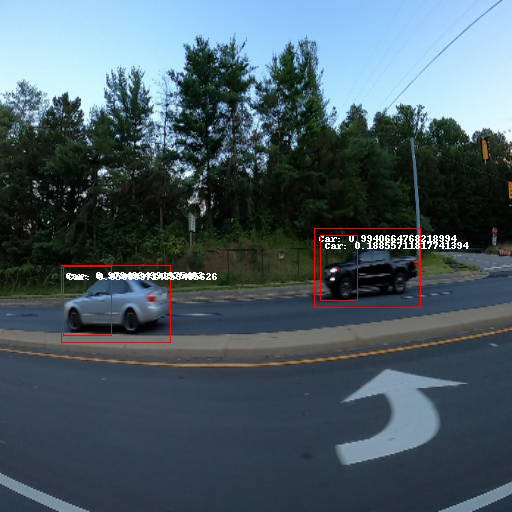

In [ ]:
# convert the image, which has been rescaled to 0-1 and had the channels flipped
pred_img = PIL.Image.fromarray((img.permute(1, 2, 0).mul(255).numpy()).astype(np.uint8))
draw = PIL.ImageDraw.Draw(pred_img)

img_preds = prediction[0]
for i in range(len(img_preds["boxes"])):
    x1, y1, x2, y2 = img_preds["boxes"][i]
    label = int(img_preds["labels"][i])
    score = float(img_preds["scores"][i])

    draw.rectangle(((x1, y1), (x2, y2)), outline="red")
    text = f'{"Car"}: {score}'
    draw.text((x1+5, y1+5), text)

display(pred_img)

Now, let's further filter out the non-confident detections with the confidence threshold of 0.75.

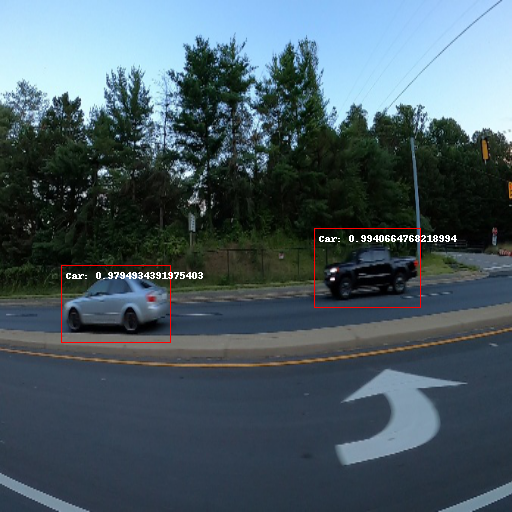

In [ ]:
det_threshold = 0.75

# convert the image, which has been rescaled to 0-1 and had the channels flipped
pred_img = PIL.Image.fromarray((img.permute(1, 2, 0).mul(255).numpy()).astype(np.uint8))
draw = PIL.ImageDraw.Draw(pred_img)

for i in range(len(img_preds["boxes"])):
    x1, y1, x2, y2 = img_preds["boxes"][i]
    label = int(img_preds["labels"][i])
    score = float(img_preds["scores"][i])

    # filter out non-confident detections
    if score > det_threshold:
        draw.rectangle(((x1, y1), (x2, y2)), outline="red")
        text = f'{"Car"}: {score}'
        draw.text((x1+5, y1+5), text)

display(pred_img)

Much better! Now I can save my model weights.

In [ ]:
# save model weights
save_path = os.path.join(BASE_FOLDER, "model", "fasterrcnn_weights.pth")
torch.save(model.state_dict(), save_path)